In [1]:
## Connect Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [9]:
#! pip install segmentation_models 

In [26]:
## Importing libraries
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import img_to_array 
import segmentation_models as sm
import random
from tensorflow.keras.utils import to_categorical

In [38]:
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
print(os.listdir("/content/gdrive/MyDrive/dataset"))

SIZE = 256 

['image', 'mask']


In [4]:
# Capture training images and convert to numpy array
training_images = glob.glob("/content/gdrive/MyDrive/dataset/image/*.tif")
training_images.sort()

images = [cv2.imread(image, 1) for image in training_images] 
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis = 3)

In [5]:
# Capture training images, sorting and converting to numpy array
training_mask = glob.glob("/content/gdrive/MyDrive/dataset/mask/*.tif")
training_mask.sort()

masks = [cv2.imread(mask, 0) for mask in training_mask]
mask_dataset = np.array(masks)

In [6]:
print("Total images in the original dataset are: ", len(training_images))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  20
Image data shape is:  (20, 256, 256, 3)
Mask data shape is:  (20, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1]


In [11]:
#Changing framework to keras
sm.set_framework('tf.keras')

In [12]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [13]:
mask_dataset.shape

(20, 256, 256)

In [21]:
labels = np.expand_dims(mask_dataset, axis=3)

In [22]:
labels.shape

(20, 256, 256, 1)

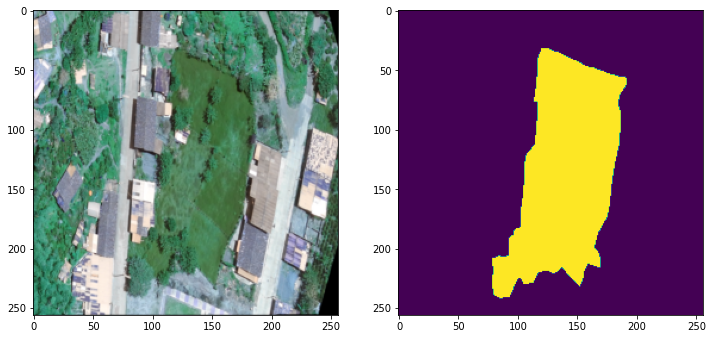

In [16]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

Unique labels in label dataset are:  [0 1]


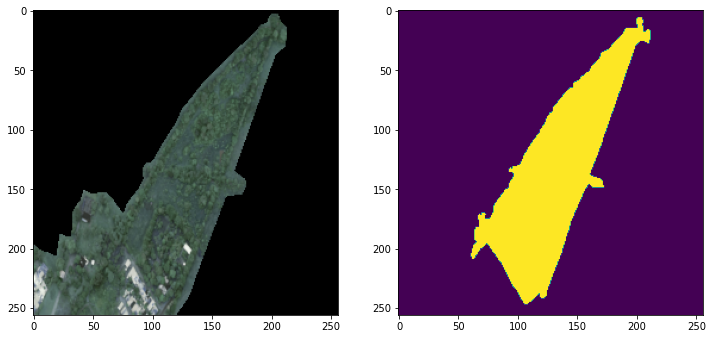

In [24]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [27]:
n_classes = len(np.unique(labels)) # 2 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

In [30]:
### Modeling
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [31]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [32]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='sigmoid')

85521592/85521592 [==============================] - 14s 0us/step


In [43]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [44]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [45]:
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
1/1 [==============================] - 17s 17s/step - loss: 0.7482 - accuracy: 0.5550 - val_loss: 0.6805 - val_accuracy: 0.5271
Epoch 2/100
1/1 [==============================] - 0s 283ms/step - loss: 0.5866 - accuracy: 0.6806 - val_loss: 0.7140 - val_accuracy: 0.4505
Epoch 3/100
1/1 [==============================] - 0s 285ms/step - loss: 0.4614 - accuracy: 0.8013 - val_loss: 0.9167 - val_accuracy: 0.3191
Epoch 4/100
1/1 [==============================] - 0s 279ms/step - loss: 0.3730 - accuracy: 0.8638 - val_loss: 1.1840 - val_accuracy: 0.2713
Epoch 5/100
1/1 [==============================] - 0s 277ms/step - loss: 0.3073 - accuracy: 0.9078 - val_loss: 1.5339 - val_accuracy: 0.2565
Epoch 6/100
1/1 [==============================] - 0s 281ms/step - loss: 0.2620 - accuracy: 0.9275 - val_loss: 2.2399 - val_accuracy: 0.2515
Epoch 7/100
1/1 [==============================] - 0s 274ms/step - loss: 0.2250 - accuracy: 0.9405 - val_loss: 3.2679 - val_accuracy: 0.2497
Epoch 8/100
1/

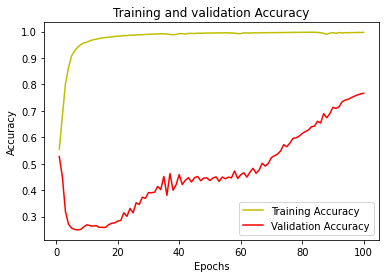

In [46]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
# Saving model
model_resnet_backbone.save('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf5')

In [48]:
model = load_model('/content/gdrive/MyDrive/Agroforestry/resnet_backbone.hdf5') # loading model...

In [49]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 1s 758ms/step


In [50]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 1s 727ms/step


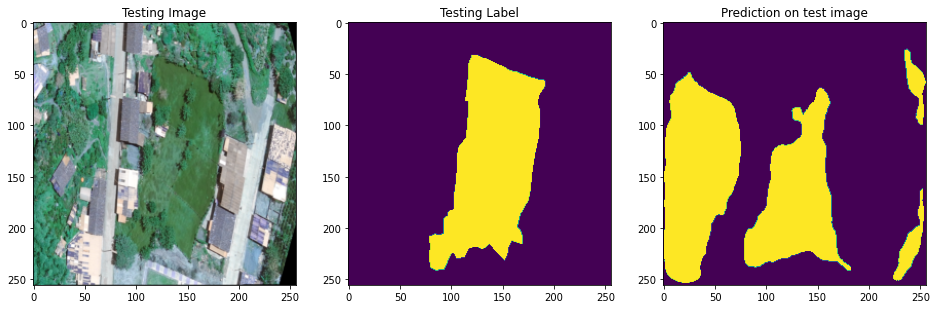

In [51]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
#label encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [ ]:
#Normalize images
image_dataset = image_dataset /255.

In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
#Load VGG16 model without classifier/fully connected layers
#Load imagenet weights for extracting features
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


#We are not using any trainable layers here.....just using pretrained weights
for layer in VGG_model.layers:
	layer.trainable = False

# No trainable parameters(important)    
VGG_model.summary()  

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
# Extract only 2 conv layers/blocks
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
# Extract features from convolutional layers
features = new_model.predict(X_train)

1/1 [==============================] - 8s 8s/step


In [ ]:
#Reassign 'features' as X 
X=features

# Reshape X to match with labels that can be used for XGBoost model

X = X.reshape(-1, X.shape[3])  

print(X.shape)

(1638400, 64)


In [ ]:
#Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(1638400,)


In [ ]:
np.unique(Y)

array([0, 1])

In [ ]:
#XGBOOST

import xgboost as xgb

model = xgb.XGBClassifier(learning_rate=0.5,n_estimators=100, max_depth=3)  

#Define gpu_id, otherwise it uses CPU and would take longer
#model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)


In [ ]:
# Train the model on training data. I used default parameters
model.fit(X, Y)

XGBClassifier()

In [ ]:
#Can try fine tuning it.
#XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              #colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              #learning_rate=0.1, max_delta_step=0, max_depth=3,
              #min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              #nthread=None, objective='multi:softprob', random_state=0,
              #reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              #silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [ ]:
#Save model for future use

filename = '/content/gdrive/MyDrive/HOTimages/model_XGB.sav'

In [ ]:
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Load model
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
X_test_features=new_model.predict(X_test)
X_test_features=X_test_features.reshape(-1, X_test_features.shape[3])
print(X_test_features.shape)

1/1 [==============================] - 0s 375ms/step
(458752, 64)


In [ ]:
# Predict using trained XGB model
y_pred = loaded_model.predict(X_test_features)
print(y_pred.shape)

(458752,)


In [ ]:
test_labels = y_test.reshape(-1)
print(test_labels.shape)

(458752,)


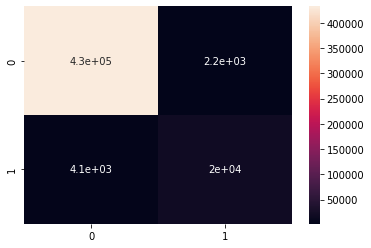

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
#Print overall accuracy not just pixel accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, y_pred))

Accuracy =  0.9863564627511161


In [ ]:
#IOU(Intersection over Union)
from keras.metrics import MeanIoU

#Using built in keras function

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_labels, y_pred)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.87455106


1/1 [==============================] - 0s 149ms/step


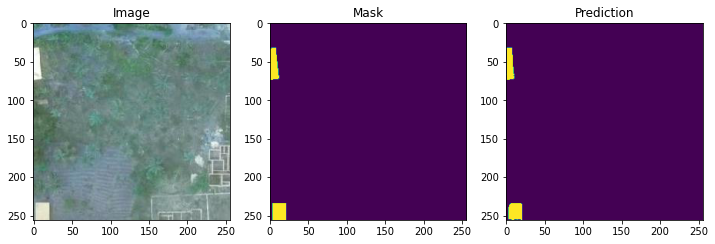

In [ ]:
import random
img_number = random.randint(0, len(X_test)-1)
img = X_test[img_number]
img=np.expand_dims(img, axis=0)

img_features=new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = loaded_model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_mask)
plt.show()